# Scientific Impact of Nobel Prize Winning Papers 

### Author: Shirley Wang


## Question

Among Nobel Prize winners in Physics, Chemistry, and Biology, what is the relationship between scientific impact of a paper and the timing of the paper during a scientist's career? Does this relationship depend on a scientist's age, gender, team size, or prize category?  For this report I will be examining these questions by conducting regression analysis to see if there are any significant relationships found, and if there are any evident confounders from the other variables.  

## Data

The data is gathered in a combination from the [publication records of Nobel laureates](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6NJ5RN) and the [Nobel Prize Developer Zone](https://www.nobelprize.org/about/developer-zone-2/).  For the Nobel Prize Developer Zone json data, after downloading I've manually gone into the file to delete the metadata at the end.  The two datasets used are from different sources, so I've had to join them together using a messy method of matching both last name and award year to join the datasets (since publication records only has the last names).

I will be measuring scientific impact by number of citations, since it is easily gathered, and quantifiable and easy to interpret.  If a paper has more citations of it, that means more people have examined and used its results to their own research, so we will say this paper has a 'higher scientific impact', and similarly vice versa. 

I will define the 'Timing' of a paper during a scientist's career as the number of the paper (how many papers has this person published before publishing this paper) divided by the amount of total papers the scientist has published in their entire career, multiplied by 100 to give a percentage like number so that it is easier to interpret.  This assumes that all papers ever published by the scientists are present within the dataset, and the dataset only contains Physics, Chemistry, and Biology papers, so it also assumes that the scientist stayed within these topics for their entire career (which is a fair assumption).

I will also be looking at other variables like AgeToPublish (the age they were when the paper was published), AgeToAward (the age they were when the paper won an award), PublishToAward (the amount of time from the paper being published to its impact being recognized and it receiving an award), Gender, TeamSize (number of people who worked on the paper), Prize Category, PubYear (the year the paper was published), and AwardYear (the year the paper was given the award).  

In [1]:
from habanero import counts
from habanero import cn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from patsy import dmatrices
from IPython.display import display

sns.set(style="whitegrid")

In [2]:
# get publication records 

physics = pd.read_csv("Physics publication record.tab", sep='\t')
physics["Category"] = "Physics"

chemistry = pd.read_csv("Chemistry_publication_record.csv")
chemistry["Category"] = "Chemistry"

medicine = pd.read_csv("Medicine publication record.tab", sep='\t')
medicine["Category"] = "Physiology or Medicine"

allpapers = physics.append(chemistry)
allpapers = allpapers.append(medicine)

In [3]:
# get timing in career
allpapers["Timing"] = allpapers.groupby("Laureate ID")["Pub year"].rank(pct=True) * 100

# set as number
allpapers["AwardYear"] = allpapers["Prize year"].apply(lambda x : int(x))

In [4]:
# get award winning papers with doi for stats
awardpapers = allpapers[allpapers["Is prize-winning paper"] == "YES"].reset_index(drop = True)
awardpaperswithdoi = awardpapers[awardpapers["DOI"].notna()].reset_index(drop = True)

In [5]:
# clean names for merging
for i, r in awardpaperswithdoi.iterrows():
    if '.' in r["Laureate name"]:
        if len(r["Laureate name"]) - r["Laureate name"].index('.') < 4:
            awardpaperswithdoi.loc[i, "Laureate name"] = r["Laureate name"][0:r["Laureate name"].index('.')]
    if ',' in r["Laureate name"]:
        awardpaperswithdoi.loc[i, "Laureate name"] = r["Laureate name"][0:r["Laureate name"].index(',')]

awardpaperswithdoi = awardpaperswithdoi.rename(columns={"Laureate name": "lowerLastName"})

In [6]:
# get laureates data
laureates = pd.read_json("laureates_all.json", orient = "records")
laureates = laureates.drop(columns = ["id", "knownName", "givenName", 
                                      "links", 'orgName', 'nativeName', 'acronym', 
                                      'founded', 'penName'])

In [7]:
# cleaning laureates data data

# last names for merging
lastnames = []
for names in laureates["familyName"]:
    if pd.isna(names):
        lastnames.append(np.nan)
    else:
        lastnames.append(names["en"].lower())

laureates["lowerLastName"] = lastnames

# get birthdates
birthdates = []
for birthinfo in laureates["birth"]:
    if pd.isna(birthinfo):
        birthdates.append(np.nan)
    else:
        birthdates.append(birthinfo["date"])

laureates["birthdate"] = birthdates

# get awards data, just getting first since easier
awardYears = []
category = []

for prizeinfo in laureates["nobelPrizes"]:
    awardYears.append(prizeinfo[0]["awardYear"])
    category.append(prizeinfo[0]["category"]["en"])

laureates["AwardYear"] = awardYears
laureates["Category"] = category

laureates = laureates[laureates["Category"].isin(["Physiology or Medicine", "Physics", "Chemistry"])]
laureates["BirthYear"] = laureates["birthdate"].apply(lambda x : int(str(x)[0:4]))
laureates["AwardYear"] = laureates["AwardYear"].apply(lambda x : int(x))

In [8]:
# merge dataframes
laureates_data = pd.merge(laureates, awardpaperswithdoi, how="inner", on=["lowerLastName", "Category", "AwardYear"])

In [9]:
# get citation counts
laureates_data["CitationCount"] = laureates_data["DOI"].apply(lambda x : counts.citation_count(doi = x))

In [10]:
# get age: birth to pub year
# get pub to award year
laureates_data["AgeToPublish"] = laureates_data["Pub year"] - laureates_data["BirthYear"]
laureates_data["AgeToAward"] = laureates_data["AwardYear"] - laureates_data["BirthYear"]
laureates_data["PublishToAward"] = laureates_data["AwardYear"] - laureates_data["Pub year"]

In [ ]:
# get team size
def get_team_count(doi):
    try:
        info = cn.content_negotiation(ids = doi)
        authors = info[info.index("author") + 10 : info.index("title") - 4]
        return len(authors.split(" and "))
    except:
        return 1

laureates_data["TeamSize"] = laureates_data["DOI"].apply(lambda x : get_team_count(x))

In [ ]:
# drop unneeded rows
not_needed = ["Is prize-winning paper", "birth", "death", "birthdate", "Laureate ID", "Title", 
              "Journal", "Affiliation", "lowerLastName", "familyName", "Prize year"]
laureates_data = laureates_data.drop(columns = not_needed)

# drop rows without necessary data for analysis
laureates_data = laureates_data[laureates_data["Timing"].notna()].reset_index(drop=True)

laureates_data = laureates_data.rename(columns={"Pub year": "PubYear"})

## Methods

CitationCount represents counts, is nonnegative, and its distribution is very right-skewed.  Due to this, I have decided to conduct a Poisson regression on CitationCount with Timing as the predictor, to see if there seems to be any relationship between the two.  

A confounding variable can be one that has correlation with both the predictor and response variables, influencing both in the relationship.  To look for possible confounding variables, I will observe the correlations between CitationCount, Timing, and the other variables in the dataset to see if there are any that meet this criteria.  I will also conduct more regressions with the additional variables added in, to see if it significantly changes the impact of Timing in the relationship.  

## Results

### Initial Regression

The Poisson Regression of predictor Timing with response variable CitationCount:

In [ ]:
y, X = dmatrices("CitationCount ~ Timing", data=laureates_data, return_type='dataframe')

# poisson regression
poisson_model = sm.GLM(y, X, family=sm.families.Poisson(sm.families.links.log()))
poisson_results = poisson_model.fit()

check = poisson_results.summary()
check = str(check).split("\n")
#check.pop(8)
check.pop(9)
check.pop(9)
print("\n".join(check))

From the results of the Poisson regression, we have a significant negative coefficient for Timing, which implies that there is a relationship between scientific impact and timing in a scientist's career.  This means that for a 1 unit increase in Timing (a 1% increase in the number of papers published up until the paper in a scientist's career), the expected number of CitationCount will decrease by a multiplicative factor of 99.47%.  This model claims that a prize-winning paper published at the end of a scientist's career will only have around 60% of the citations of a prize-winning paper published at the very start of a scientist's career.

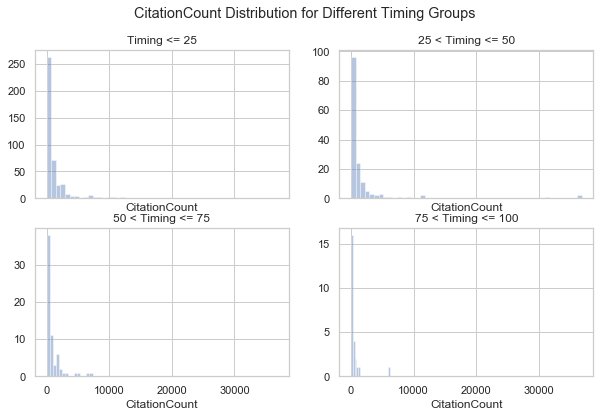

In [65]:
# compare citation counts by timing

group1 = laureates_data[laureates_data["Timing"] <= 25]
group2 = laureates_data[(laureates_data["Timing"] > 25) & (laureates_data["Timing"] <= 50)]
group3 = laureates_data[(laureates_data["Timing"] > 50) & (laureates_data["Timing"] <= 75)]
group4 = laureates_data[(laureates_data["Timing"] > 75) & (laureates_data["Timing"] <= 100)]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
sns.distplot(group1["CitationCount"], kde=False, ax=axs[0, 0])
sns.distplot(group2["CitationCount"], kde=False, ax=axs[0, 1])
sns.distplot(group3["CitationCount"], kde=False, ax=axs[1, 0])
sns.distplot(group4["CitationCount"], kde=False, ax=axs[1, 1])

axs[0, 0].set_title("Timing <= 25")
axs[0, 1].set_title("25 < Timing <= 50")
axs[1, 0].set_title("50 < Timing <= 75")
axs[1, 1].set_title("75 < Timing <= 100")
plt.suptitle("CitationCount Distribution for Different Timing Groups")
#plt.tight_layout()
plt.show()

Viewing the distribution of CitationCount in four different groups based on Timing, they all resemble each other, but as Timing increases, we can see that the distribution of CitationCount becomes narrower and its mean becomes smaller, which does support the regression results that an increase in Timing results in a decrease in CitationCounts.  It should also be noted that as Timing increases the number of observations in that group decreases, which could indicate problems with this analysis.

### Correlations

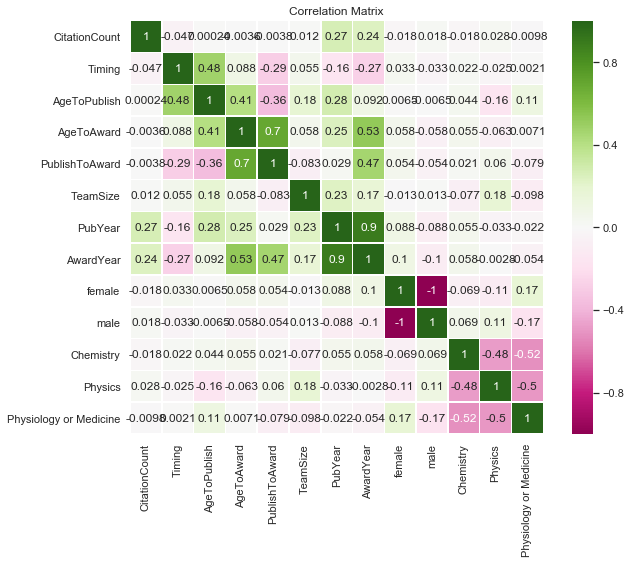

In [48]:
# view correlation matrix to see possible confounders
data = laureates_data[["CitationCount", "Timing", "AgeToPublish", "AgeToAward", "PublishToAward",
                      "gender", "TeamSize", "Category", "PubYear", "AwardYear"]]
gender = pd.get_dummies(data["gender"])
category = pd.get_dummies(data["Category"])
data = pd.concat([data, gender, category], axis=1)
corrMatrix = data.corr()

plt.figure(figsize = (10, 8))
plt.title("Correlation Matrix")
sns.heatmap(corrMatrix, annot=True, square = True, linewidths=0.5, cmap = "PiYG")

# to prevent top and bottom from getting cut off awkwardly
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.tight_layout()
plt.savefig("corrs")

plt.show()

Viewing the correlation matrix, we can see that there isn't a strong correlation between Citation Count and any of the possible predictors.  PubYear and AwardYear both appear to have some correlation with CitationCount and Timing, so they are possible confounding variables.

There is a some relevant correlation between Timing and AgeToPublish, and some correlation with AgeToAward and PublishToAward.  This implies that these ages might be possible confounding variables.  The way Timing is calculated makes it very likely to be related to AgeToPublish, which may be the reason for this correlation though, so it is hard to claim if AgeToPublish is a confounding variable or not.

Other significant correlations are between male and the three categories, although this could be attributed to how an overwhelming majority of the laureates are male, and the three categories with each other, which is expected since they're dummy variables and if one of them is 1 the others must be 0, as well as PubYear and AwardYear, suggesting that the amount of time it takes to get an award after publishing a paper is somewhat predictable.

In the data, we have 657 males but only 16 females.  Due to this overwhelming inbalance in data between the groups, I have chosen to not conduct further analysis on it.

We can also note that the correlation between Citation Counts and Timing is only -0.033, already very small, so even though the regression results said that there was a significant negative relationship, there is still room for suspicion.

### More Regressions

#### Continuous Variables:

To see how the other variables affect the relationship between Timing and CitationCount, I ran the regression CitationCount ~ Timing with one additional variable each time to see if the impact of Timing on CitationCount changes drastically.

In [111]:
# get new regressions

timing_coefs = []
other_coefs = []
timing_pvalues = []
other_pvalues = []
other_vars = ["AwardYear", "PubYear", "AgeToPublish", "AgeToAward", "PublishToAward", "TeamSize"]
formulas = []
aics = []

# for baseline in table
formulas.append("CitationCount ~ Timing")
y, X = dmatrices("CitationCount ~ Timing", data=data, return_type='dataframe')
poisson_model = sm.GLM(y, X, family=sm.families.Poisson(sm.families.links.log()))
poisson_results = poisson_model.fit()

timing_coefs.append(poisson_results.params["Timing"])
other_coefs.append("N/A")
timing_pvalues.append(round(poisson_results.pvalues["Timing"], -1))
other_pvalues.append("N/A")
aics.append(round(poisson_results.aic, -4))

for new_var in other_vars:
    formulas.append("CitationCount ~ Timing + " + new_var)
    y, X = dmatrices("CitationCount ~ Timing + " + new_var, data=data, return_type='dataframe')
    poisson_model = sm.GLM(y, X, family=sm.families.Poisson(sm.families.links.log()))
    poisson_results = poisson_model.fit()

    timing_coefs.append(poisson_results.params["Timing"])
    other_coefs.append(poisson_results.params[new_var])
    timing_pvalues.append(round(poisson_results.pvalues["Timing"], 4))
    other_pvalues.append(round(poisson_results.pvalues[new_var], 4))
    aics.append(round(poisson_results.aic, -3))
    
other_vars = ["None", "AwardYear", "PubYear", "AgeToPublish", "AgeToAward", "PublishToAward", "TeamSize"]

In [112]:
regression_results = pd.DataFrame({"Added Variable": other_vars, "Timing Coefficient": timing_coefs, 
                                   "Timing P-Value": timing_pvalues, "Other Coefficient": other_coefs, 
                                   "Other P-Value": other_pvalues, "AIC": aics})

latex = regression_results.to_latex (index = False)
display({'text/latex': latex}, raw = True)

The table shows the changes in the regression output each time.  Each time, the regression claims that all the predictors are very significant.  The most drastic change in Timing occurs when AwardYear and AgeToPublish are added into the model.  When AwardYear is added, the coefficient for Timing becomes positive, and when AgeToPublish is added to the model, the coefficient for Timing decreases the most.  Due to the method that I calculate AgeToPublish, it's probably very correlated with Timing and as a result its hard to claim any concrete results for it.  But for AwardYear, we seem to have evidence that the year a paper was awarded with the nobel prize is a confounding variable in the relationship between Timing and CitationCount.

#### Categorical Variable:


For the prize categories, I split the data into only papers for that prize category to examine the seperate regressions for the three groups, with the same regression of CitationCount ~ Timing each time.

In [113]:
# make a table of coefficients for the three categories
timing_coefs = []
timing_pvalues = []
aics = []
category = ["Physics", "Chemistry", "Physiology or Medicine"]

# for baseline in table
y, X = dmatrices("CitationCount ~ Timing", data=data, return_type='dataframe')
poisson_model = sm.GLM(y, X, family=sm.families.Poisson(sm.families.links.log()))
poisson_results = poisson_model.fit()

timing_coefs.append(poisson_results.params["Timing"])
timing_pvalues.append(round(poisson_results.pvalues["Timing"], -3))
aics.append(round(poisson_results.aic, -3))

for cat in category:
    y, X = dmatrices("CitationCount ~ Timing", data=data[data[cat] == 1], return_type='dataframe')
    poisson_model = sm.GLM(y, X, family=sm.families.Poisson(sm.families.links.log()))
    poisson_results = poisson_model.fit()

    timing_coefs.append(poisson_results.params["Timing"])
    timing_pvalues.append(round(poisson_results.pvalues["Timing"], -3))
    aics.append(round(poisson_results.aic, -3))
    
category = ["All", "Physics", "Chemistry", "Physiology or Medicine"]

In [114]:
regression_results = pd.DataFrame({"Category of Data": category, "Timing Coefficient": timing_coefs, 
                                   "Timing P-Value": timing_pvalues, "AIC": aics})

latex = regression_results.head().to_latex (index = False)
display({'text/latex': latex}, raw = True)

From here we can see that the coefficient for Timing changes a lot between each prize category.  Notable, while Physics and Physiology or Medicine still have negative coefficients, Chemistry now has a positive coefficient, implying that prize winning papers about Chemistry are actually getting more citations if they were published later in a scientist's career.  This seems to imply that prize category is another confounding variable in the relationship between Timing and CitationCount.

## Conclusions

There appears to be a small impact the timing of a paper published has on the number of citations the paper will get later on in life, saying that papers that came out earlier in a scientist's careers will have more citations that papers that came out later.  However, even though the model claims it is significant, the change predicted by the model is still very small, and even if this relationship is true, the decrease in impact is very small and not something scientists should worry about too much.

Other possible factors that might be influencing the relationship are AwardYear, AgeToPublish, and Category of the paper.  There appears to be a positive relationship between the year a paper got the award and the number of citations it has, implying that overall, the more recently a paper receieved its award the more it'll be cited.  This might be due to the increase in technology in recent years, making the papers more accessible online and overall easier to read and cite.  AgeToPublish also could be a factor, and it claims that the older a person is when the paper is published the more it will be cited.  The category also seems to be influencing the relationship, notably with it claiming that Chemistry papers actually get more impact with a later timing while Physics and Biology papers lose impact with later timing.

Overall, there may be some relationship between timing of a paper and the scientific impact of the paper, but it is small compared to the impact other factors have on the scientific impact of a paper.

### Considerations

The dataset I'm working with has 673 observations in it, since I'm looking only at nobel prize award winning papers, and only papers that have a DOI present in the dataset.  The data is not incredibly large, since there is a limited number of nobel prize winners.  There are 4 people who actually won two nobel prizes in the data, but I've only considered their first prize for simplicity's sake.  As well, there are people who won a nobel prize for their work on a specific topic, which can encompass multiple papers published at different times.  For example, in this dataset, Alexis Carrel received a Nobel Prize in 1912 for four different papers.

The results of this report does rely a lot on the python package habanero for accurate citation counts and citation information about the papers.  I also made the assumption that all authors listed on the paper are all the people on the main team that worked on the research, when it is entirely possible that there are many others who also worked on the research but just aren't listed as an author.

Some of the data was not kept due to encoding mistakes, since not all the laureate names were not encoded in the same way.  The Nobel Prize API kept each laureate's full name, while the publication records usually only kept their last names, sometimes abbreviated and sometimes not, and sometimes their full name but in a different format, so some data was lost in the joining due to formatting problems.  As well, joining the dataset on last name and award year is prone to some errors, and more data could have been lost as a result.

Future analysis could include comparing the results between prizewinning papers and non-prizewinning papers, to see if the relationship between Timing and CitationCount was influenced by the fact that the paper itself won an award or not.  Is this effect of decreasing scientific impact only present in prize-winning papers, or is it present in all papers published by a scientist.  Should scientists be more worried about how much of an impact their work is creating as they progress through life, or does that only apply to specific people who have won the prestigious Nobel Prize?